# Setting

In [1]:
from pf_utils import PortfolioManager as PM 
from pf_utils import FinancialRatios, METRICS, FundDownloader
from pf_widgets import WidgetUniverse, WidgetTransaction, w_date

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
path_data = 'data'
path_tran = 'transaction'

In [3]:
file_cost='transaction_cost'
kw_cost = {'cost': file_cost}

# Data

In [4]:
universe = 'UV_FUND'
fund = PM.create_universe(universe)
cost = PM.get_cost(universe, file=file_cost, path=path_tran)
fee = cost['fee']

64 securities from 2008-11-28 to 2024-11-29 uploaded.
REMINDER: 64 equities converted to daily (days in year: 365)
Daily metrics in Performance statistics must be meaningless
Price data loaded
Cost data transaction_cost_241217.csv loaded


In [5]:
tickers = {k:v for k,v in fund.security_names.items() if 'TDF2045' in v}
tickers = list(tickers.keys())

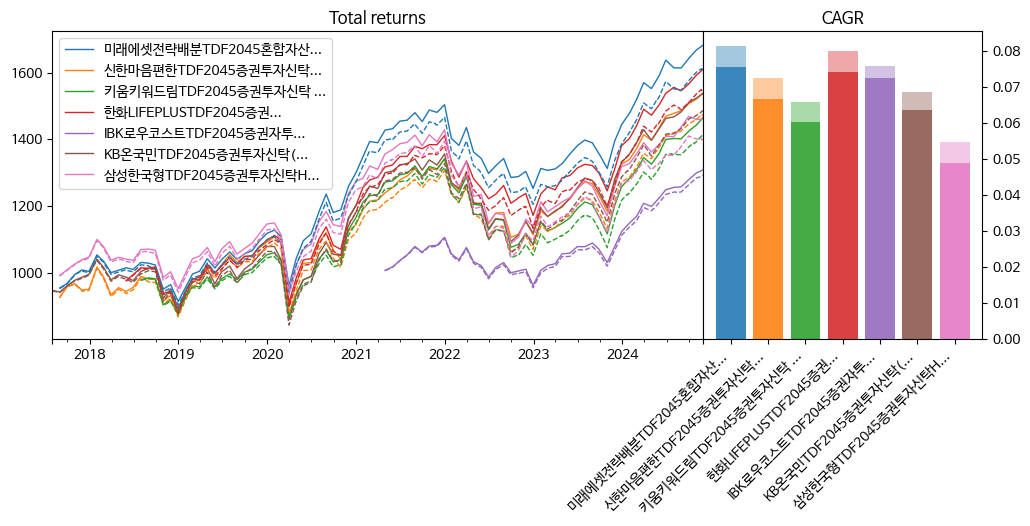

In [6]:
#m = 'total_return'
m = 'cagr'
fund.plot(tickers, fee=fee, base=-1, metric=m)

In [87]:
df = fund.df_prices[tickers]
df= df.loc[df.notna().any(axis=1)]

w = 365 * 2
df_ror = df.rolling(w).apply(lambda x: x.iloc[-1] / x.iloc[0] - 1).apply(lambda x: x.dropna())

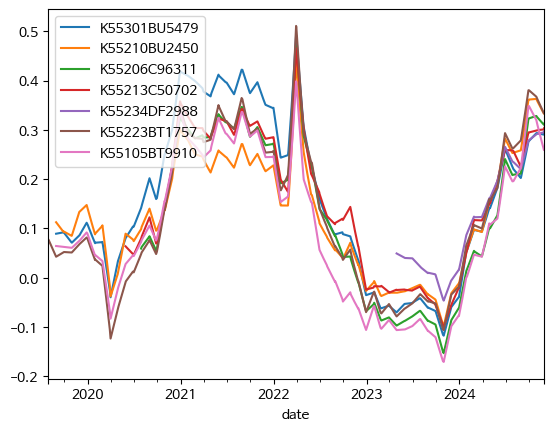

In [88]:
_ = df_ror.plot()

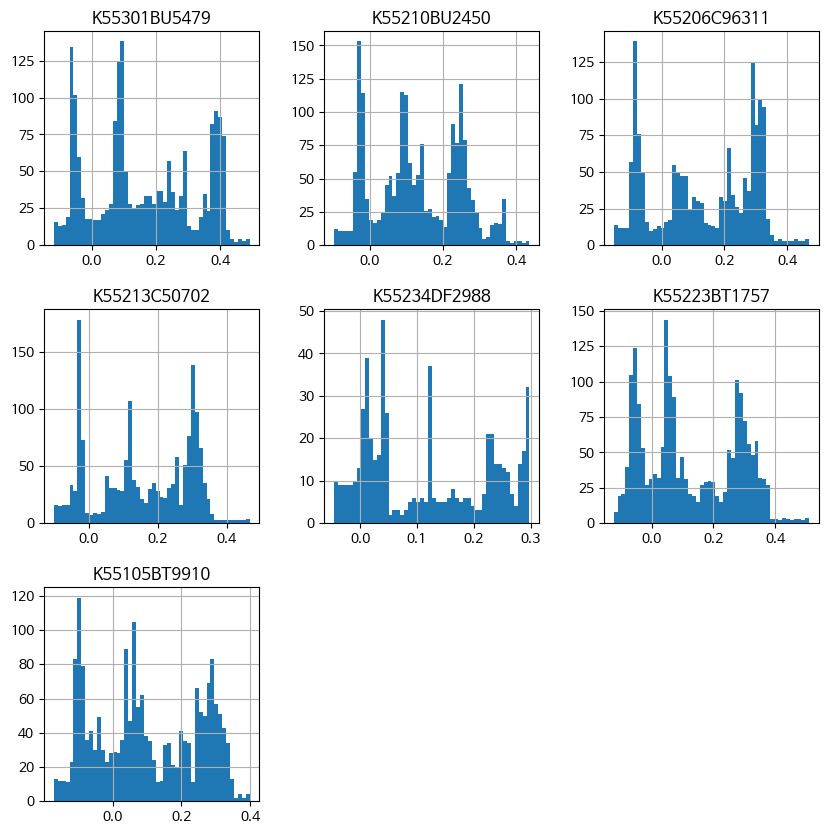

In [89]:
_ = df_ror.hist(bins=50, figsize=(10,10))

In [90]:
df_ror.apply(lambda x: x.loc[x > 0].dropna().count() / x.dropna().count())

K55301BU5479    0.781657
K55210BU2450    0.783220
K55206C96311    0.731230
K55213C50702    0.767922
K55234DF2988    0.886403
K55223BT1757    0.742051
K55105BT9910    0.693069
dtype: float64

In [65]:
df_ror.agg(['mean', 'std'])

,K55301BU5479,K55210BU2450,K55206C96311,K55213C50702,K55234DF2988,K55223BT1757,K55105BT9910
mean,0.080419,0.070898,0.076937,0.086856,0.059451,0.068864,0.053951
std,0.125761,0.113316,0.134982,0.120978,0.097699,0.133971,0.125645


In [12]:
from pf_utils import performance_stats, METRICS

In [13]:
performance_stats(df, metrics=METRICS)

,K55301BU5479,K55210BU2450,K55206C96311,K55213C50702,K55234DF2988,K55223BT1757,K55105BT9910
start,2021-04-30,2021-04-30,2021-04-30,2021-04-30,2021-04-30,2021-04-30,2021-04-30
end,2024-11-29,2024-11-29,2024-11-29,2024-11-29,2024-11-29,2024-11-29,2024-11-29
total_return,0.178707,0.242023,0.152964,0.222988,0.3,0.183772,0.077007
cagr,0.046946,0.062344,0.040515,0.057775,0.075954,0.048199,0.020916
calmar,0.281089,0.354791,0.204636,0.340782,0.581994,0.248329,0.087668
max_drawdown,-0.167016,-0.17572,-0.197987,-0.169537,-0.130506,-0.194095,-0.238581
avg_drawdown,-0.043088,-0.052399,-0.059419,-0.04835,-0.051307,-0.080494,-0.070569
avg_drawdown_days,201.2,225.25,249.5,227.5,272.0,309.666667,282.75
daily_vol,0.014031,0.015662,0.016776,0.013997,0.012462,0.016591,0.017853
daily_sharpe,2.263009,2.672159,1.641891,2.775797,4.059676,1.965997,0.808911


# Bayesian

In [10]:
from pf_utils import BayesianEstimator

In [7]:
df_prices = fund.df_prices[tickers]

In [8]:
df_prices = fund._get_prices_after_fee(df_prices, fee)

In [11]:
be = BayesianEstimator(df_prices, 365)

In [12]:
be.get_stats(align_period=False)

,K55301BU5479,K55210BU2450,K55206C96311,K55213C50702,K55234DF2988,K55223BT1757,K55105BT9910
start,2017-08-31,2017-08-31,2018-07-31,2018-05-31,2021-04-30,2017-07-31,2017-08-31
end,2024-11-29,2024-11-29,2024-11-29,2024-11-29,2024-11-29,2024-11-29,2024-11-29
total_return,0.69376,0.596193,0.448976,0.592729,0.284767,0.572539,0.413679
cagr,0.075421,0.066653,0.060312,0.074238,0.072421,0.063688,0.04893
calmar,0.423466,0.347398,0.292162,0.400553,0.537732,0.306088,0.196465
max_drawdown,-0.178104,-0.191862,-0.206431,-0.185338,-0.134679,-0.208071,-0.24905
avg_drawdown,-0.032562,-0.038188,-0.048158,-0.03423,-0.020203,-0.044197,-0.047641
avg_drawdown_days,110.833333,107.111111,141.75,85.473684,108.375,135.066667,152.214286
daily_vol,0.017833,0.020625,0.020287,0.02029,0.012634,0.021193,0.020135
daily_sharpe,2.822383,2.168937,2.001944,2.445431,3.824997,2.020761,1.647051


In [13]:
be.bayesian_sample(freq='2y')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus_two, mu, sig, ror]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


In [14]:
var_names = ['ror', 'sharpe']
be.bayesian_summary(var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ror[K55301BU5479],0.148,0.165,-0.142,0.468,0.002,0.002,8032.0,3183.0,1.0
ror[K55210BU2450],0.115,0.122,-0.118,0.333,0.001,0.001,8593.0,2671.0,1.0
ror[K55206C96311],0.122,0.161,-0.174,0.421,0.002,0.002,6551.0,3357.0,1.0
ror[K55213C50702],0.144,0.140,-0.121,0.417,0.002,0.002,6382.0,2684.0,1.0
ror[K55234DF2988],0.111,0.113,-0.097,0.323,0.001,0.001,7500.0,3083.0,1.0
ror[K55223BT1757],0.117,0.153,-0.167,0.405,0.002,0.002,8327.0,3037.0,1.0
ror[K55105BT9910],0.085,0.156,-0.209,0.376,0.002,0.002,7411.0,2867.0,1.0
sharpe[K55301BU5479],0.899,0.028,0.849,0.950,0.000,0.000,10355.0,3182.0,1.0
sharpe[K55210BU2450],0.957,0.028,0.903,1.009,0.000,0.000,7293.0,2740.0,1.0
sharpe[K55206C96311],0.755,0.029,0.698,0.807,0.000,0.000,9512.0,3276.0,1.0


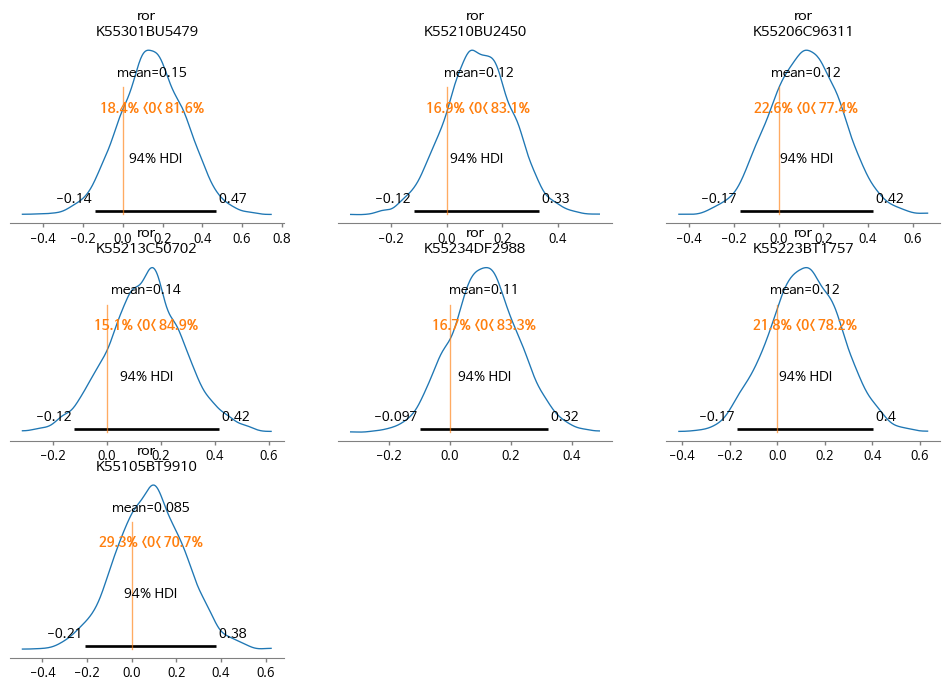

In [15]:
be.plot_posterior(var_names[0], figsize=(12,8), textsize=9)

In [16]:
def plot_compare(self, var_names, sample=None, figsize=(6,5)):
    if self.bayesian_data is None:
        return print('ERROR: run bayesian_sample first')
    else:
        trace = self.bayesian_data['trace']

    if isinstance(var_names, str):
        var_names = [var_names]
        
    stacked = az.extract(trace)
    vn = [x for x in var_names if x not in stacked.keys()]
    if len(vn) > 0:
        v = ', '.join(var_names)
        return print(f'ERROR: Check if {v} exit')

    fig, axes = plt.subplots(1, len(var_names), figsize=figsize)
    for i, v in enumerate(var_names):
        df = stacked[v].to_dataframe()
        df = (df[v].droplevel(['chain','draw'])
                   .reset_index().pivot(columns="ticker")
                   .droplevel(0, axis=1))
        _ = df.plot.kde(ax=axes[i])
    return axes

import arviz as az
from matplotlib import pyplot as plt
be.plot_compare = lambda *a, **k: plot_compare(be, *a, **k)

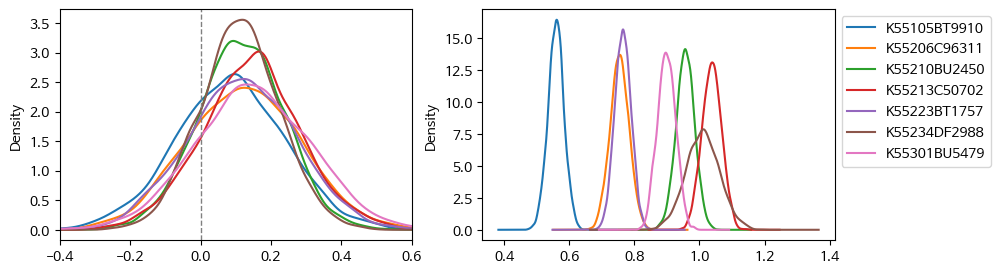

In [17]:
axes = be.plot_compare(var_names, figsize=(10,3))
_ = axes[0].set_xlim(-0.4, 0.6)
_ = axes[0].axvline(0, c='grey', lw=1, ls='--')
_ = axes[0].get_legend().remove()
_ = axes[1].legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')

# Bayesian 2

In [47]:
from pf_utils import BayesianEstimator, performance_stats, get_date_range

In [48]:
df_prices = fund.df_prices
df_prices = fund._get_prices_after_fee(df_prices, fee)

In [49]:
n = 365 * 5
tickers = get_date_range(df_prices)
tickers = tickers.loc[tickers['n'] >= n].index.to_list()
df_prices = df_prices[tickers]
len(tickers)

57

In [50]:
tickers = performance_stats(df_prices, sort_by='cagr').iloc[:, :10].columns.to_list()
df_prices = df_prices[tickers]

In [51]:
be = BayesianEstimator(df_prices, 365)

In [52]:
be.get_stats(sort_by='cagr')

,K55364CF7048,K55303BT4176,K55301BM7459,K55301BU5479,K55301BM7640,K55301BU6253,K55213C50702,K55234BY9966,K55223BT1922,K55365BT3694
start,2019-04-30,2017-11-30,2017-03-31,2017-08-31,2017-03-31,2017-08-31,2018-05-31,2017-12-29,2017-07-31,2017-08-31
end,2024-11-29,2024-11-29,2024-11-29,2024-11-29,2024-11-29,2024-11-29,2024-11-29,2024-11-29,2024-11-29,2024-11-29
total_return,0.705722,0.768898,0.806826,0.69376,0.745044,0.685307,0.592729,0.579819,0.615443,0.544039
cagr,0.100327,0.084917,0.080224,0.075421,0.075333,0.074679,0.074238,0.068333,0.0676,0.061774
calmar,0.451043,0.275892,0.464783,0.423466,0.475284,0.434778,0.400553,0.17224,0.301541,0.186426
max_drawdown,-0.222434,-0.307791,-0.172605,-0.178104,-0.1585,-0.171763,-0.185338,-0.396728,-0.224183,-0.331363
avg_drawdown,-0.033717,-0.072877,-0.029751,-0.032562,-0.027502,-0.032562,-0.03423,-0.077548,-0.04643,-0.100929
avg_drawdown_days,107.071429,251.222222,100.75,110.833333,98.6,109.5,85.473684,218.8,135.4,331.428571
daily_vol,0.022387,0.024205,0.017082,0.017833,0.015805,0.017284,0.02029,0.032826,0.022467,0.028858
daily_sharpe,2.958069,2.335503,3.12562,2.822383,3.178669,2.883856,2.445431,1.40585,2.020165,1.447621


In [53]:
be.bayesian_sample(freq='1y')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus_two, mu, sig, ror]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 88 seconds.


In [54]:
var_names = ['ror', 'sharpe']
be.bayesian_summary(var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ror[K55303BT4176],0.111,0.270,-0.390,0.618,0.003,0.004,6924.0,2501.0,1.0
ror[K55364CF7048],0.106,0.161,-0.194,0.412,0.002,0.002,7864.0,3097.0,1.0
ror[K55365BT3694],0.088,0.244,-0.374,0.541,0.003,0.004,5909.0,2857.0,1.0
ror[K55234BY9966],0.094,0.247,-0.358,0.568,0.003,0.004,7257.0,3021.0,1.0
ror[K55301BU5479],0.074,0.125,-0.158,0.305,0.002,0.002,5134.0,3216.0,1.0
ror[K55301BM7459],0.075,0.120,-0.151,0.303,0.001,0.002,7142.0,3136.0,1.0
ror[K55301BU6253],0.075,0.125,-0.174,0.298,0.002,0.002,6168.0,2880.0,1.0
ror[K55223BT1922],0.069,0.148,-0.222,0.335,0.002,0.002,6607.0,2917.0,1.0
ror[K55213C50702],0.081,0.122,-0.159,0.296,0.001,0.002,7171.0,3069.0,1.0
ror[K55301BM7640],0.070,0.112,-0.134,0.289,0.001,0.002,6824.0,3018.0,1.0


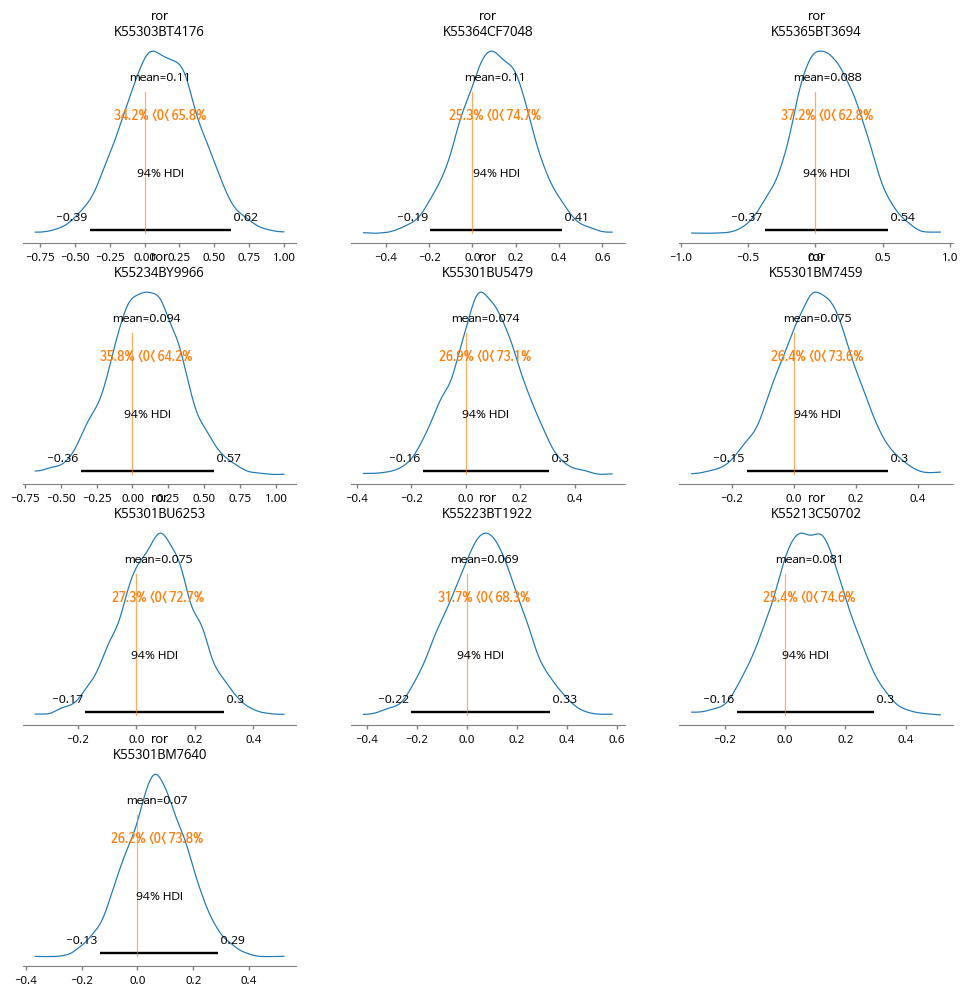

In [55]:
be.plot_posterior(var_names[0], figsize=(12,12), textsize=8)

# testing

In [11]:
be.bayesian_sample(freq='yearly', normality_sharpe=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus_two, mean, vol, yearly_returns]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


In [12]:
var_names = ['_mean', '_vol', '_returns']
be.bayesian_summary(var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
yearly_mean[K55301BU5479],0.080,0.003,0.076,0.086,0.000,0.000,8510.0,2887.0,1.0
yearly_mean[K55210BU2450],0.071,0.002,0.066,0.076,0.000,0.000,8645.0,3080.0,1.0
yearly_mean[K55206C96311],0.077,0.003,0.071,0.083,0.000,0.000,8819.0,3234.0,1.0
yearly_mean[K55213C50702],0.087,0.003,0.082,0.093,0.000,0.000,8485.0,2717.0,1.0
yearly_mean[K55234DF2988],0.060,0.003,0.054,0.066,0.000,0.000,7605.0,3063.0,1.0
yearly_mean[K55223BT1757],0.069,0.003,0.064,0.074,0.000,0.000,9539.0,3239.0,1.0
yearly_mean[K55105BT9910],0.054,0.003,0.049,0.059,0.000,0.000,7702.0,2706.0,1.0
yearly_returns[K55301BU5479],0.080,0.125,-0.170,0.303,0.001,0.002,8313.0,2536.0,1.0
yearly_returns[K55210BU2450],0.075,0.113,-0.134,0.284,0.001,0.002,7603.0,3088.0,1.0
yearly_returns[K55206C96311],0.075,0.135,-0.177,0.327,0.002,0.002,7309.0,3192.0,1.0


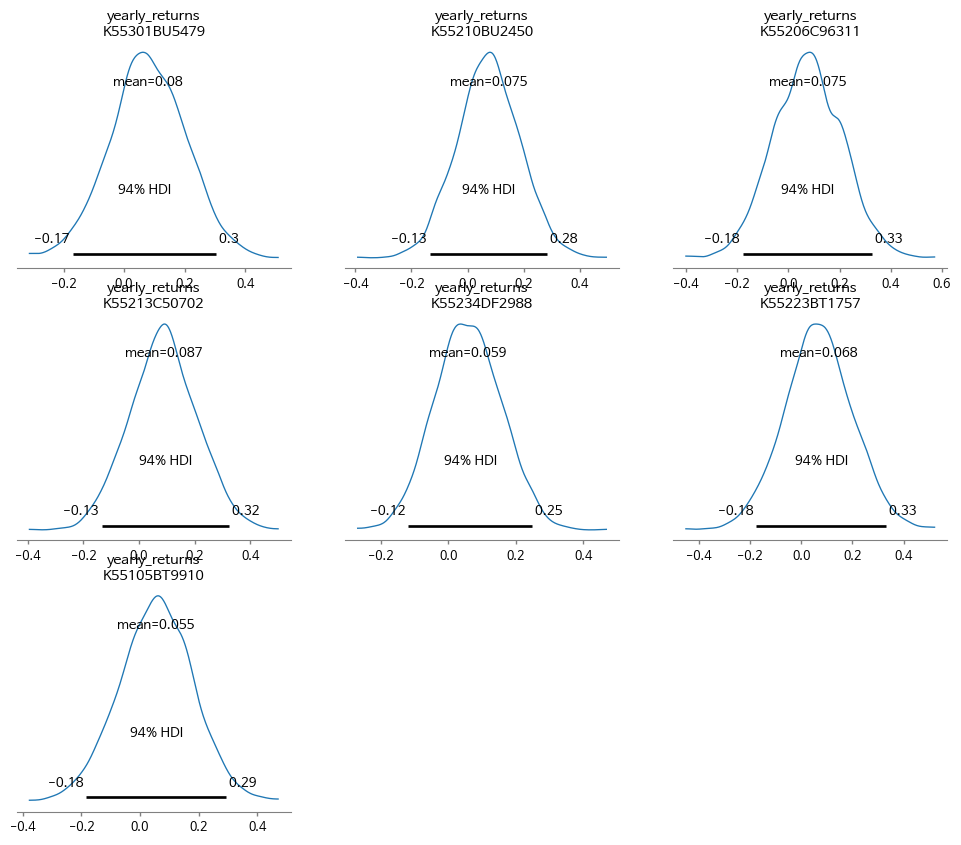

In [16]:
v = '_returns'
#v = '_mean'
be.bayesian_plot(v, figsize=(12,10), textsize=9)

In [133]:
from pf_utils import BacktestManager, BayesianEstimator


class BayesianEstimator(BayesianEstimator):

    def get_freq_days(self, freq='1Y'):
        n_t = BacktestManager.split_int_n_temporal(freq, 'M') # default month
        if n_t is None:
            return
        else:
            n, temporal = n_t        
            
        days_in_year = self.days_in_year
        cond = lambda x, y: False if x is None else x[0].lower() == y[0].lower()
        if cond(temporal, 'W'):
            n *= round(days_in_year / WEEKS_IN_YEAR)
        elif cond(temporal, 'M'):
            n *= round(days_in_year / 12)
        elif cond(temporal, 'Q'):
            n *= round(days_in_year / 4)
        elif cond(temporal, 'Y'):
            n *= days_in_year
        return n
    
    
    def bayesian_sample(self, freq='1y', rf=0, align_period=False,
                        sample_draws=1000, sample_tune=1000, target_accept=0.9,
                        multiplier_std=1000, rate_nu = 29, normality_sharpe=True):
        """
        normality_sharpe: set to True if 
         -. You are making comparisons to Sharpe ratios calculated under the assumption of normality.
         -. You want to account for the higher variability due to the heavy tails of the t-distribution.
        """
        days_in_year = self.days_in_year
        periods = self.get_freq_days(freq)
        df_prices = self.df_prices
        tickers = list(df_prices.columns)
        
        if align_period:
            df_prices = self.align_period(df_prices, axis=0, fill_na=True)
            df_ret = df_prices.pct_change(periods).dropna()
            mean_prior = df_ret.mean()
            std_prior = df_ret.std()
            std_low = std_prior / multiplier_std
            std_high = std_prior * multiplier_std
        else:
            ret_list = [df_prices[x].pct_change(periods).dropna() for x in tickers]
            mean_prior = [x.mean() for x in ret_list]
            std_prior = [x.std() for x in ret_list]
            std_low = [x / multiplier_std for x in std_prior]
            std_high = [x * multiplier_std for x in std_prior]
            ror = dict()
        
        coords={'ticker': tickers}
        with pm.Model(coords=coords) as model:
            # nu: degree of freedom (normality parameter)
            nu = pm.Exponential('nu_minus_two', 1 / rate_nu, testval=4) + 2.
            mean = pm.Normal('mu', mu=mean_prior, sigma=std_prior, dims='ticker')
            std = pm.Uniform('sig', lower=std_low, upper=std_high, dims='ticker')
            
            if align_period:
                ror = pm.StudentT('ror', nu=nu, mu=mean, sigma=std, observed=df_ret)
            else:
                func = lambda x: dict(mu=mean[x], sigma=std[x], observed=ret_list[x])
                ror = {i: pm.StudentT(f'ror[{x}]', nu=nu, **func(i)) for i, x in enumerate(tickers)}
    
            #pm.Deterministic('mean', mean, dims='ticker')
            #pm.Deterministic('std', std, dims='ticker')
            std_sr = std * pt.sqrt(nu / (nu - 2)) if normality_sharpe else std
            ror = pm.Normal('ror', mu=mean, sigma=std_sr, dims='ticker')
            sharpe = pm.Deterministic('sharpe', (mean-rf) / std_sr, dims='ticker')
    
            trace = pm.sample(draws=sample_draws, tune=sample_tune,
                              #chains=chains, cores=cores,
                              target_accept=target_accept,
                              #return_inferencedata=False, # TODO: what's for?
                              progressbar=True)
            
        self.bayesian_data = {'trace':trace, 'coords':coords, 'align_period':align_period, 
                              'freq':freq, 'rf':rf}
        return None
    
    
    def bayesian_plot(self, var_names=None, filter_vars='like', ref_val=None, **kwargs):
        if self.bayesian_data is None:
            return print('ERROR: run bayesian_sample first')
        else:
            trace = self.bayesian_data['trace']
            coords = self.bayesian_data['coords']
            freq = self.bayesian_data['freq']
            rf = self.bayesian_data['rf']
            align_period = self.bayesian_data['align_period']
    
        if ref_val is None:
            ref_val = self.get_ref_val(freq=freq, rf=rf, align_period=align_period)
            col_name = list(coords.keys())[0]
            ref_val = {k: [{col_name:at, 'ref_val':rv} for at, rv in v.items()] for k,v in ref_val.items()}
        ref_val.update({'mean diff': [{'ref_val': 0}], 'sharpe diff': [{'ref_val': 0}]})
    
        _ = az.plot_posterior(trace, var_names=var_names, filter_vars=filter_vars,
                              ref_val=ref_val, **kwargs)
        #return ref_val
        return None


    def get_ref_val(self, freq='1y', rf=0, align_period=False):
        """
        get ref val for 
        """
        df_prices = self.df_prices
        if align_period:
            df_prices = self.align_period(df_prices, axis=0, fill_na=True)
        periods = self.get_freq_days(freq)
        args = [df_prices, periods]
        return {
            'mean': self._calc_mean_return(*args).to_dict(),
            'std': self._calc_volatility(*args).to_dict(),
            'ror': self._calc_mean_return(*args).to_dict(),
            'sharpe': self._calc_sharpe(*args).to_dict()
        }

In [134]:
be = BayesianEstimator(df_prices, 365)
be.get_stats(align_period=False)

,K55301BU5479,K55210BU2450,K55206C96311,K55213C50702,K55234DF2988,K55223BT1757,K55105BT9910
start,2017-08-31,2017-08-31,2018-07-31,2018-05-31,2021-04-30,2017-07-31,2017-08-31
end,2024-11-29,2024-11-29,2024-11-29,2024-11-29,2024-11-29,2024-11-29,2024-11-29
total_return,0.7637,0.6622,0.4977,0.6503,0.3,0.6252,0.4727
cagr,0.081442,0.072633,0.065864,0.080122,0.075954,0.068478,0.054866
calmar,0.487632,0.388559,0.332667,0.441468,0.581994,0.336192,0.22997
max_drawdown,-0.167016,-0.18693,-0.197987,-0.181491,-0.130506,-0.203686,-0.238581
avg_drawdown,-0.051706,-0.066858,-0.066807,-0.061409,-0.051307,-0.079215,-0.079265
avg_drawdown_days,174.545455,185.9,181.444444,155.4,272.0,245.125,259.25
daily_vol,0.017211,0.019965,0.01976,0.019764,0.012462,0.020666,0.019501
daily_sharpe,3.147562,2.433325,2.237219,2.700721,4.059676,2.221783,1.899708


In [152]:
be.bayesian_sample(freq='3y', normality_sharpe=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus_two, mu, sig, ror]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


In [153]:
var_names = ['ror']
be.bayesian_summary(var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ror[K55301BU5479],0.257,0.136,0.005,0.516,0.002,0.001,6372.0,2941.0,1.0
ror[K55210BU2450],0.197,0.103,0.001,0.383,0.001,0.001,6677.0,3033.0,1.0
ror[K55206C96311],0.173,0.122,-0.081,0.385,0.001,0.001,8144.0,2899.0,1.0
ror[K55213C50702],0.229,0.112,0.022,0.440,0.001,0.001,6751.0,3209.0,1.0
ror[K55234DF2988],0.196,0.011,0.175,0.217,0.000,0.000,7580.0,2707.0,1.0
ror[K55223BT1757],0.201,0.102,0.008,0.389,0.001,0.001,6964.0,2873.0,1.0
ror[K55105BT9910],0.147,0.123,-0.082,0.384,0.001,0.001,7712.0,3225.0,1.0


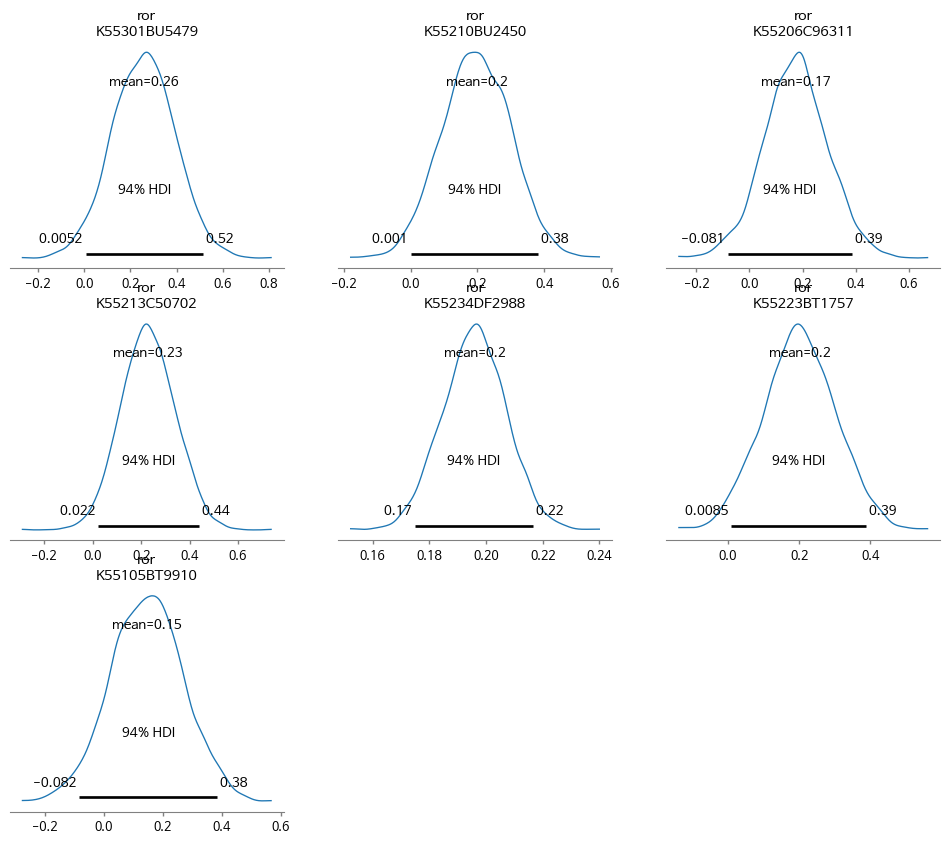

In [154]:
v = 'ror'
be.bayesian_plot(v, figsize=(12,10), textsize=9)

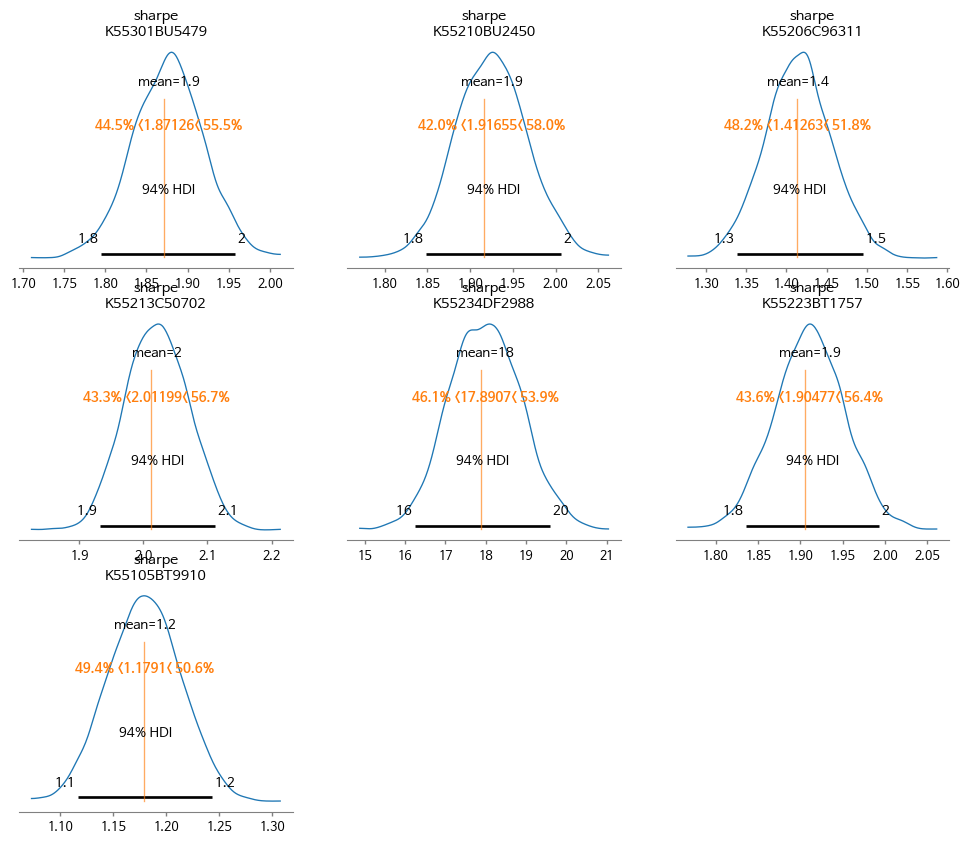

In [155]:
v = 'sharpe'
be.bayesian_plot(v, figsize=(12,10), textsize=9)

In [149]:
def _plot_compare(self, var_names, sample=None, figsize=(6,5)):
    if self.bayesian_data is None:
        return print('ERROR: run bayesian_sample first')
    else:
        trace = self.bayesian_data['trace']

    if isinstance(var_names, str):
        var_names = [var_names]
        
    stacked = az.extract(trace)
    vn = [x for x in var_names if x not in stacked.keys()]
    if len(vn) > 0:
        v = ', '.join(var_names)
        return print(f'ERROR: Check if {v} exit')

    fig, axes = plt.subplots(1, len(var_names), figsize=figsize)
    for i, v in enumerate(var_names):
        df = stacked[v].to_dataframe()
        df = df[v].droplevel(['chain','draw'])
        _ = df.reset_index().pivot(columns="ticker").plot.kde(legend=False, ax=axes[i])
    return axes

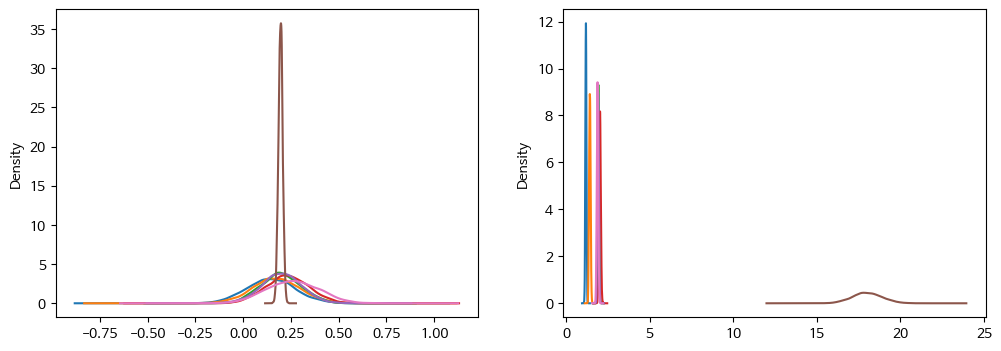

In [151]:
from matplotlib import pyplot as plt

axes = _plot_compare(be, ['ror', 'sharpe'], figsize=(12,4))
#axes[0].set_xlim(-0.4, 0.6)

In [91]:
stacked = _plot_compare(be)

In [94]:
stacked.keys()
stacked['yearly_mean']

'yearly_mean' in stacked.keys()

True

In [23]:
be.bayesian_data['trace'].to_dataframe().columns

Index([                                           'chain',
                                                   'draw',
                 ('posterior', 'mean[0]', 'K55301BU5479'),
                 ('posterior', 'mean[1]', 'K55210BU2450'),
                 ('posterior', 'mean[2]', 'K55206C96311'),
                 ('posterior', 'mean[3]', 'K55213C50702'),
                 ('posterior', 'mean[4]', 'K55234DF2988'),
                 ('posterior', 'mean[5]', 'K55223BT1757'),
                 ('posterior', 'mean[6]', 'K55105BT9910'),
                            ('posterior', 'nu_minus_two'),
                  ('posterior', 'vol[0]', 'K55301BU5479'),
                  ('posterior', 'vol[1]', 'K55210BU2450'),
                  ('posterior', 'vol[2]', 'K55206C96311'),
                  ('posterior', 'vol[3]', 'K55213C50702'),
                  ('posterior', 'vol[4]', 'K55234DF2988'),
                  ('posterior', 'vol[5]', 'K55223BT1757'),
                  ('posterior', 'vol[6]', 'K55105BT9910'

In [ ]:
#be.bayesian_data['trace'].to_dataframe(('posterior', '_returns'), filter_groups='like')
be.bayesian_data['trace'].to_dataframe('yearly_returns', filter_groups='like')

In [31]:
import arviz as az
data = be.bayesian_data['trace']
group = 'posterior'
data = az.convert_to_dataset(data, group=group)

In [35]:
data.to_dataframe()

mean  nu_minus_two       vol  yearly_mean  \
chain draw ticker                                                        
0     0    K55301BU5479  0.079398    274.632129  0.128950     0.079398   
           K55210BU2450  0.070571    274.632129  0.115130     0.070571   
           K55206C96311  0.078560    274.632129  0.137464     0.078560   
           K55213C50702  0.084864    274.632129  0.119295     0.084864   
           K55234DF2988  0.060757    274.632129  0.095318     0.060757   
...                           ...           ...       ...          ...   
3     999  K55206C96311  0.077569    276.978295  0.134271     0.077569   
           K55213C50702  0.089934    276.978295  0.118927     0.089934   
           K55234DF2988  0.055504    276.978295  0.095607     0.055504   
           K55223BT1757  0.072483    276.978295  0.133120     0.072483   
           K55105BT9910  0.055580    276.978295  0.124332     0.055580   

                         yearly_returns  yearly_sharpe  yearly_vol  
chain draw ticker                                                   
0     0    K55301BU5479        0.229438       0.615730    0.128950  
           K55210BU2450       -0.104925       0.612963    0.115130  
           K55206C96311       -0.078571       0.571497    0.137464  
           K55213C50702        0.255116       0.711381    0.119295  
           K55234DF2988        0.002076       0.637416    0.095318  
...                                 ...            ...         ...  
3     999  K55206C96311        0.297946       0.577707    0.134271  
           K55213C50702        0.113708       0.756211    0.118927  
           K55234DF2988        0.374136       0.580543    0.095607  
           K55223BT1757        0.065225       0.544496    0.133120  
           K55105BT9910        0.195315       0.447029    0.124332  

[28000 rows x 7 columns]

In [ ]:
#be.bayesian_data['trace'].observed_data
be.bayesian_data['trace']

In [95]:
idata = be.bayesian_data['trace']
#stacked = az.extract(idata, num_samples=1000)
stacked = az.extract(idata)
df = stacked.yearly_returns.to_dataframe()
df = df['yearly_returns'].droplevel([1,2])
df

ticker
K55301BU5479    0.229438
K55301BU5479   -0.006783
K55301BU5479   -0.002159
K55301BU5479    0.173155
K55301BU5479    0.023356
                  ...   
K55105BT9910   -0.048665
K55105BT9910    0.172756
K55105BT9910   -0.070639
K55105BT9910   -0.018793
K55105BT9910    0.195315
Name: yearly_returns, Length: 28000, dtype: float64

In [99]:
stacked.yearly_returns.to_dataframe()

chain  draw  yearly_returns
ticker       chain draw                             
K55301BU5479 0     0         0     0        0.229438
                   1         0     1       -0.006783
                   2         0     2       -0.002159
                   3         0     3        0.173155
                   4         0     4        0.023356
...                        ...   ...             ...
K55105BT9910 3     995       3   995       -0.048665
                   996       3   996        0.172756
                   997       3   997       -0.070639
                   998       3   998       -0.018793
                   999       3   999        0.195315

[28000 rows x 3 columns]

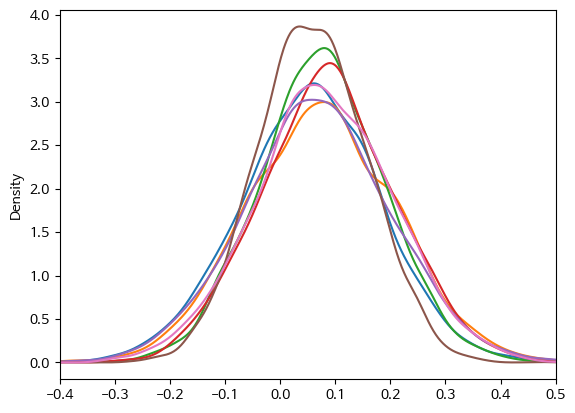

In [84]:
#df.reset_index().rename_axis('index').unstack()
#ax = df.reset_index().pivot(columns="ticker").plot(kind='density', legend=False)
ax = df.reset_index().pivot(columns="ticker").plot.kde(legend=False)
#axt = ax.twinx()
#df.reset_index().pivot(columns="ticker").plot(kind='hist', bins=50, legend=False, ax=axt)
_ = ax.set_xlim(-0.4, 0.5)

In [86]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

# testing

In [33]:
self = be
freq = 'yearly'
align_period = False
sample_draws=1000
sample_tune=1000
target_accept=0.9
multiplier_std=1000
rate_nu = 29
normality_sharpe=True

periods, freq = self.get_freq_days(freq)
df_prices = self.df_prices
tickers = list(df_prices.columns)

if align_period:
    df_prices = self.align_period(df_prices, axis=0, fill_na=True)
    df_ret = df_prices.pct_change(periods).dropna()
    mean_prior = df_ret.mean()
    std_prior = df_ret.std()
    std_low = std_prior / multiplier_std
    std_high = std_prior * multiplier_std
else:
    ret_list = [df_prices[x].pct_change(periods).dropna() for x in tickers]
    mean_prior = [x.mean() for x in ret_list]
    std_prior = [x.std() for x in ret_list]
    std_low = [x / multiplier_std for x in std_prior]
    std_high = [x * multiplier_std for x in std_prior]
    returns = dict()

In [34]:
std_low

[0.00012595733968587513,
 0.00011343515471378028,
 0.00013518279980760496,
 0.00012112679024075862,
 9.784103969534989e-05,
 0.00013414263815029963,
 0.00012580430362237128]

In [35]:
std_high

[125.95733968587514,
 113.43515471378028,
 135.18279980760494,
 121.12679024075862,
 97.84103969534988,
 134.14263815029963,
 125.80430362237126]

In [36]:
std_prior

[0.12595733968587514,
 0.11343515471378028,
 0.13518279980760495,
 0.12112679024075862,
 0.09784103969534988,
 0.13414263815029964,
 0.12580430362237127]

In [29]:
from pf_utils import performance_stats
df = df_prices.loc[df_prices.notna().any(axis=1)]
#performance_stats(df, align_period=False)

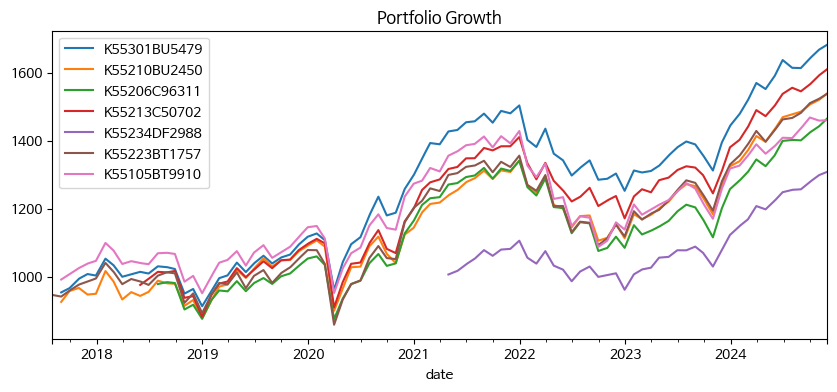

In [30]:
be.plot_historical()

In [48]:
be._calc_mean_return(df_prices, 365, 365)

K55301BU5479    0.080617
K55210BU2450    0.071058
K55206C96311    0.077100
K55213C50702    0.087058
K55234DF2988    0.059571
K55223BT1757    0.069022
K55105BT9910    0.054064
dtype: float64

In [50]:
periods = 31
days_in_year = 365
be._calc_mean_return(df_prices, periods, days_in_year, False)

K55301BU5479    0.006974
K55210BU2450    0.006222
K55206C96311    0.005821
K55213C50702    0.006916
K55234DF2988    0.006352
K55223BT1757    0.006176
K55105BT9910    0.004951
dtype: float64

In [51]:
periods = 31
days_in_year = 365
be._calc_mean_return(df_prices, periods, days_in_year)

K55301BU5479    0.082108
K55210BU2450    0.073264
K55206C96311    0.068535
K55213C50702    0.081435
K55234DF2988    0.074793
K55223BT1757    0.072721
K55105BT9910    0.058297
dtype: float64

In [37]:
def _calc_mean_return(self, df_prices, periods, days_in_year, annualize=True):
    m = (periods/days_in_year) if annualize else 1
    return df_prices.apply(lambda x: x.pct_change(periods).dropna().mean()).apply(lambda x: (1+x)**m-1)

In [45]:
periods = 31
days_in_year = 365
_calc_mean_return(be, df_prices, periods, days_in_year)

K55301BU5479    0.000590
K55210BU2450    0.000527
K55206C96311    0.000493
K55213C50702    0.000586
K55234DF2988    0.000538
K55223BT1757    0.000523
K55105BT9910    0.000420
dtype: float64

In [47]:
w = 31
df_prices = df
df= df.loc[df.notna().any(axis=1)]
df.rolling(w).apply(lambda x: x.iloc[-1] / x.iloc[0] - 1).apply(lambda x: x.dropna()).mean()

K55301BU5479    0.006745
K55210BU2450    0.006022
K55206C96311    0.005628
K55213C50702    0.006690
K55234DF2988    0.006147
K55223BT1757    0.005969
K55105BT9910    0.004786
dtype: float64